<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Модель" data-toc-modified-id="Модель-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Модель</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

## Сборный проект - восстановление золота из руды

Компания «Цифра» разрабатывает решения для эффективной работы промышленных предприятий. Необходимо подготовить прототип модели машинного обучения восстановления золота из золотосодержащей руды для «Цифры». 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

**Этапы**:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

## Подготовка данных

### Загрузка данных и библиотек

In [1]:
# импортируем задействованные библиотеки
import pandas as pd
import numpy as np
from scipy import stats as st

from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# Зададим параметры отображения значений и графиков
%matplotlib inline
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:,.3f}'.format
plt.style.use('seaborn')

SEED = 666

In [3]:
# загружаем данные
try:
    gold_train = pd.read_csv('../01-data/gold_recovery_train_new.csv', parse_dates=['date'], index_col='date')
    gold_test = pd.read_csv('../01-data/gold_recovery_test_new.csv', parse_dates=['date'], index_col='date')
    gold_recovery = pd.read_csv('../01-data/gold_recovery_full_new.csv', parse_dates=['date'], index_col='date')
except FileNotFoundError:
    gold_train = pd.read_csv('/datasets/gold_recovery_train_new.csv', parse_dates=['date'], index_col='date')
    gold_test = pd.read_csv('/datasets/gold_recovery_test_new.csv', parse_dates=['date'], index_col='date')
    gold_recovery = pd.read_csv('/datasets/gold_recovery_full_new.csv', parse_dates=['date'], index_col='date')
    
print('Размерность данных:', gold_train.shape, gold_test.shape, gold_recovery.shape)


Размерность данных: (14149, 86) (5290, 52) (19439, 86)


In [4]:
gold_train.head(1)

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15,6.055,9.890,5.507,42.192,70.541,10.412,0.895,16.904,2.143,127.092,...,14.017,-502.488,12.100,-504.716,9.926,-498.310,8.080,-500.471,14.151,-605.842


<div style="border:solid #8B008B 1px; padding: 15px">

Данные представляют собой собранные за 2,5 года метрики технологического оборудования/датчиков и производные показатели, записанные в 86 переменных типа float.

Попробуем описать производственный процесс, используя собираемые в ходе него данные, а также проверим какая информация отсутствует.

### Изучение данных

Проверим как распределяются тренировочная и тестовые выборки во времени.

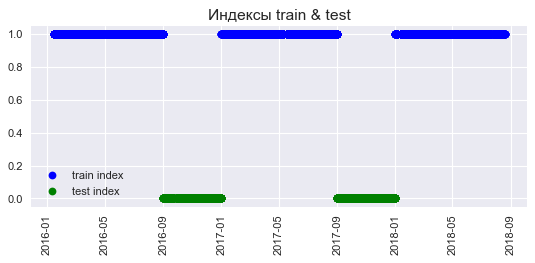

In [5]:
plt.figure(figsize=(8, 3), dpi= 80)

temp = np.ones(gold_train.shape[0])
plt.plot(pd.Series(data=temp, index=gold_train.index), 'bo', label='train index')

temp = np.zeros(gold_test.shape[0])
plt.plot(pd.Series(data=temp, index=gold_test.index), 'go', label='test index')

plt.title('Индексы train & test', fontsize=14)
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [6]:
def nan_in_cols(df, df_w_nan):
    '''
    функция считает количество пропусков в заданных столбцах,
    если столбец отсутствует ставим -1
    '''
    var = df['col_name']
    if var in df_w_nan.columns:
        return df_w_nan[var].isnull().sum()
    else:
        return -1
        
        
cols = list(gold_recovery.columns.str.split('.'))
# таблица с анализом переменных
process_structure = (pd.DataFrame(cols, columns=['stage', 'par_type', 'par_name'])
                     # подсчитаем пропуски
                     .assign(
                         col_name = gold_recovery.columns,
                         recovery_nan = lambda x: x.apply(nan_in_cols, df_w_nan=gold_recovery, axis=1),
                         train_nan = lambda x: x.apply(nan_in_cols, df_w_nan=gold_train, axis=1),
                         test_nan = lambda x: x.apply(nan_in_cols, df_w_nan=gold_test, axis=1),
                         # контрольный столбец
                         check_nan = lambda x: 
                             x.apply(lambda x: (x['recovery_nan'] - x['train_nan'] - x['test_nan']) 
                                     if x['test_nan'] > 0 else (x['recovery_nan'] - x['train_nan']), axis=1)
                     )
                     .drop('col_name', axis=1)
                     # отсортируем таблицу по стадиям производства
                     .set_index('stage')
                     .loc[['rougher', 'primary_cleaner', 'secondary_cleaner', 'final']]
                     .reset_index()
                     )

In [7]:
# выводим переменные с пропусками во всех датасетах
process_structure

,stage,par_type,par_name,recovery_nan,train_nan,test_nan,check_nan
0,rougher,calculation,sulfate_to_au_concentrate,2,1,-1,1
1,rougher,calculation,floatbank10_sulfate_to_au_feed,2,1,-1,1
2,rougher,calculation,floatbank11_sulfate_to_au_feed,2,1,-1,1
3,rougher,calculation,au_pb_ratio,0,0,-1,0
4,rougher,input,feed_ag,0,0,0,0
5,rougher,input,feed_pb,100,100,0,0
6,rougher,input,feed_rate,11,8,3,0
7,rougher,input,feed_size,145,144,1,0
8,rougher,input,feed_sol,99,78,21,0
9,rougher,input,feed_au,0,0,0,0


In [8]:
# сгруппируем переменные 
metrics_by_process = (process_structure.groupby(['stage', 'par_type'],sort=False)
                      ['par_name'].agg(['count', 'unique'])
                    #   .reset_index()
                      )
print('Структура техпроцесса в признаках:')
metrics_by_process#.iloc[:, 0]

Структура техпроцесса в признаках:


count  \
stage             par_type             
rougher           calculation      4   
                  input           10   
                  output           9   
                  state           12   
primary_cleaner   input            4   
                  output           8   
                  state            8   
secondary_cleaner output           4   
                  state           18   
final             output           9   

                                                                          unique  
stage             par_type                                                        
rougher           calculation  [sulfate_to_au_concentrate, floatbank10_sulfat...  
                  input        [feed_ag, feed_pb, feed_rate, feed_size, feed_...  
                  output       [concentrate_ag, concentrate_pb, concentrate_s...  
                  state        [floatbank10_a_air, floatbank10_a_level, float...  
primary_cleaner   input               [sulfate, depressant, feed_size, xanthate]  
                  output       [concentrate_ag, concentrate_pb, concentrate_s...  
                  state        [floatbank8_a_air, floatbank8_a_level, floatba...  
secondary_cleaner output                   [tail_ag, tail_pb, tail_sol, tail_au]  
                  state        [floatbank2_a_air, floatbank2_a_level, floatba...  
final             output       [concentrate_ag, concentrate_pb, concentrate_s...

In [9]:
 
process_structure[process_structure.test_nan == -1].groupby(['stage', 'par_type'],sort=False)['par_name'].agg(['count', 'unique'])
                     

count  \
stage             par_type             
rougher           calculation      4   
                  output           9   
primary_cleaner   output           8   
secondary_cleaner output           4   
final             output           9   

                                                                          unique  
stage             par_type                                                        
rougher           calculation  [sulfate_to_au_concentrate, floatbank10_sulfat...  
                  output       [concentrate_ag, concentrate_pb, concentrate_s...  
primary_cleaner   output       [concentrate_ag, concentrate_pb, concentrate_s...  
secondary_cleaner output                   [tail_ag, tail_pb, tail_sol, tail_au]  
final             output       [concentrate_ag, concentrate_pb, concentrate_s...

In [10]:
pd.set_option('display.max_rows', 50)

In [11]:
# можем посмотреть какие переменные описывают каждый техпроцесс
pd.DataFrame(metrics_by_process.reset_index()['unique'].to_list(), index=metrics_by_process.index)

0   \
stage             par_type                                 
rougher           calculation  sulfate_to_au_concentrate   
                  input                          feed_ag   
                  output                  concentrate_ag   
                  state                floatbank10_a_air   
primary_cleaner   input                          sulfate   
                  output                  concentrate_ag   
                  state                 floatbank8_a_air   
secondary_cleaner output                         tail_ag   
                  state                 floatbank2_a_air   
final             output                  concentrate_ag   

                                                           1   \
stage             par_type                                      
rougher           calculation  floatbank10_sulfate_to_au_feed   
                  input                               feed_pb   
                  output                       concentrate_pb   
                  state                   floatbank10_a_level   
primary_cleaner   input                            depressant   
                  output                       concentrate_pb   
                  state                    floatbank8_a_level   
secondary_cleaner output                              tail_pb   
                  state                    floatbank2_a_level   
final             output                       concentrate_pb   

                                                           2   \
stage             par_type                                      
rougher           calculation  floatbank11_sulfate_to_au_feed   
                  input                             feed_rate   
                  output                      concentrate_sol   
                  state                     floatbank10_b_air   
primary_cleaner   input                             feed_size   
                  output                      concentrate_sol   
                  state                      floatbank8_b_air   
secondary_cleaner output                             tail_sol   
                  state                      floatbank2_b_air   
final             output                      concentrate_sol   

                                                3                  4   \
stage             par_type                                              
rougher           calculation          au_pb_ratio               None   
                  input                  feed_size           feed_sol   
                  output            concentrate_au           recovery   
                  state        floatbank10_b_level  floatbank10_c_air   
primary_cleaner   input                   xanthate               None   
                  output            concentrate_au            tail_ag   
                  state         floatbank8_b_level   floatbank8_c_air   
secondary_cleaner output                   tail_au               None   
                  state         floatbank2_b_level   floatbank3_a_air   
final             output            concentrate_au           recovery   

                                                5                    6   \
stage             par_type                                                
rougher           calculation                 None                 None   
                  input                    feed_au  floatbank10_sulfate   
                  output                   tail_ag              tail_pb   
                  state        floatbank10_c_level    floatbank10_d_air   
primary_cleaner   input                       None                 None   
                  output                   tail_pb             tail_sol   
                  state         floatbank8_c_level     floatbank8_d_air   
secondary_cleaner output                      None                 None   
                  state         floatbank3_a_level     floatbank3_b_air   
final             output                   tail_ag              tail_

In [12]:
# выведем, названия переменных отсутствующих в test
excluded_from_test = sorted(list(set(gold_train.columns) - set(gold_test.columns)))
print(f'В тестовой выборке в сравнении с тренировочной отсутствуют {len(excluded_from_test)} переменных: {excluded_from_test}')

В тестовой выборке в сравнении с тренировочной отсутствуют 34 переменных: ['final.output.concentrate_ag', 'final.output.concentrate_au', 'final.output.concentrate_pb', 'final.output.concentrate_sol', 'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_au', 'final.output.tail_pb', 'final.output.tail_sol', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol', 'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_au', 'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol', 'rougher.calculation.au_pb_ratio', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.calculation.sulfate_to_au_concentrate', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_au', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol', 'rougher.output.recovery', 'rougher.output.tail_ag'

### Технология производства и данные

**Технология производства**

Добытая руда дробится и отправляется на обогащение (фтотацию) и  очистку.

1. **Флотация**. Во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов.
На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости).

2. **Очистка**. Черновой концентрат проходит две очистки. На выходе получается финальный концентрат и новые отвальные хвосты.

**Термины**

**Технологический процесс**
* Rougher feed — исходное сырье
* Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
  * Xanthate — ксантогенат (промотер, или активатор флотации);
  * Sulphate — сульфат (на данном производстве сульфид натрия);
  * Depressant — депрессант (силикат натрия).
* Rougher process (англ. «грубый процесс») — флотация
* Rougher tails — отвальные хвосты
* Float banks — флотационная установка
* Cleaner process — очистка
* Rougher Au — черновой концентрат золота
* Final Au — финальный концентрат золота

**Параметры этапов**
* air amount — объём воздуха
* fluid levels — уровень жидкости
* feed size — размер гранул сырья
* feed rate — скорость подачи

------
Наши данные - это выборка переменных из техпроцесса (gold_recovery) и выделенные из нее подвыборки gold_train и gold_test. 

В данных представлены метрики трех технологических переделов и финальные показатели по продукту - обогащенному полуфабрикату золотоносной руды. Каждый передел описывают несколько типов признаков - параметры входящего сырья, параметры выходящего продукта (и сопутствующих фракций) и какие-то показатели рабочего оборудования (самая многочисленная группа признаков - 38). 

В тестовой выборке в сравнении с тренировочной отсутствуют 34 переменных - все, описывающие продукт на выходе (output) плюс калькуляции на стадии флотации.

В выборках имеются в целом незначительные пропуски, причем в исходной выборке (recovery) их больше, чем в производных (train и test).

-------
Проверим насколько производные метрики совпадают с представленными в данных - рассчитаем эффективность обогащения породы (recovery) на стадии флотации в тренировочной выборке и сравним с представленным в выборке. Наибольшие пропуски - около 9% данных - в переменной secondary_cleaner.output.


Эффективность обогащения рассчитывается по формуле

\begin{align}
{Recovery} = \frac{C\times(F-T)}{F\times(C-T)}\times100\%
\end{align}

где:
* C — доля золота в концентрате после флотации/очистки - rougher.output.concentrate_au
* F — доля золота в сырье/концентрате до флотации/очистки - rougher.input.feed_au
* T — доля золота в отвальных хвостах после флотации/очистки - rougher.output.tail_au


In [13]:
def recovery(C, F, T):
    # функция расчета эффективности обогащения
    return (C*(F-T)) / (F*(C-T)) * 100
    
c, f, t = gold_train['rougher.output.concentrate_au'], gold_train['rougher.input.feed_au'], gold_train['rougher.output.tail_au']

In [14]:
train_recovery = (pd.DataFrame([gold_train['rougher.output.recovery'], recovery(c, f, t)]).T
                 .reset_index()
                 )
train_recovery.columns = ['date', 'base', 'calculation']
train_recovery['dev'] = train_recovery['base'] - train_recovery['calculation']
train_recovery.describe()

,base,calculation,dev
count,"14,149.000","14,149.000","14,149.000"
mean,82.705,82.705,0.000
std,14.479,14.479,0.000
min,0.000,-0.000,-0.000
25%,79.993,79.993,-0.000
50%,85.299,85.299,0.000
75%,90.165,90.165,0.000
max,100.000,100.000,0.000


Как видно, статистики двух распределений идентичны, а отклонения стремятся к нулю. Посчитаем MAE.

In [15]:
print(f'Среднее абсолюное отклонение между представленным в данных и расчетным показателями MAE = {mean_absolute_error(train_recovery.base, train_recovery.calculation)}')

Среднее абсолюное отклонение между представленным в данных и расчетным показателями MAE = 9.73512347450521e-15


Таким образом, показатель recovery представлен в данных верно, проверка выявила минимальные отклонения, связанные скорее всего с особенностями округления чисел.

### Предобработка данных

Пропуски в тестовой выборке незначительны, в то время как в тренировочной их довольно много.

In [16]:
gold_train.shape[0] - gold_train.dropna().shape[0]

3132

Если просто удалить все пропуски мы потеряем 3132 объекта наблюдений или почти 22% тренировочной выборки, что существенно. 
Посмотрим как можно заполнить имеющиеся пропуски.

Имеем много пропусков в параметрах состояния флотационных установок. Данные представляют фактически временные ряды, в которых с часовым интервалом фиксируются некие параметры. Можно предположить, что параметры установок не могут меняться кардинально в течение нескольких часов, т.е. они меняются постепенно. Поэтому мы можем заполнить пропуски в данных параметрах на основе значений ближайших соседей. Метод interpolate решает такую проблему.

In [17]:
# заполняем NaN с помощью интерполяции во времени
gold_train[gold_train.columns[gold_train.columns.str.contains('floatbank')]] = \
    gold_train[gold_train.columns[gold_train.columns.str.contains('floatbank')]]\
    .interpolate(method='time')

Остальные пропуски оценим непосредственно перед моделированием и будем уже в процессе машинного обучения принимать решения о способе их заполнения/удаления.

## Анализ данных

### Содержание металлов в концентрате

Изучим как меняется концентрация трех основных металлов на различных этапах очистки.

In [18]:
# золото
au = ['au', ['rougher.input.feed_au', 'rougher.output.concentrate_au', 
      'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']]
      
# серебро
ag = ['ag', ['rougher.input.feed_ag', 'rougher.output.concentrate_ag', 
      'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']]
          
# свинец
pb = ['pb', ['rougher.input.feed_pb', 'rougher.output.concentrate_pb',
      'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']]


In [19]:
tuple(gold_recovery.loc[:, au[1]])

('rougher.input.feed_au',
 'rougher.output.concentrate_au',
 'primary_cleaner.output.concentrate_au',
 'final.output.concentrate_au')

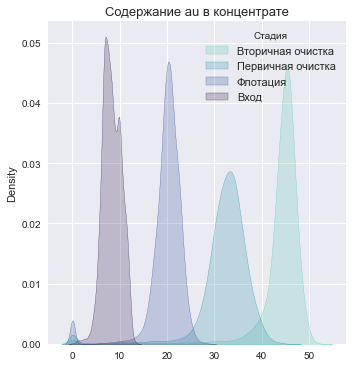

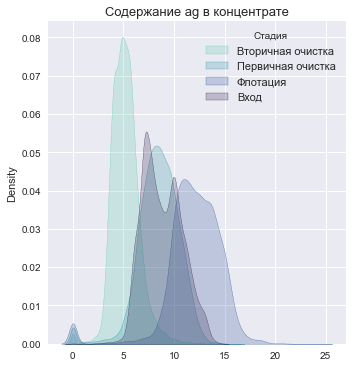

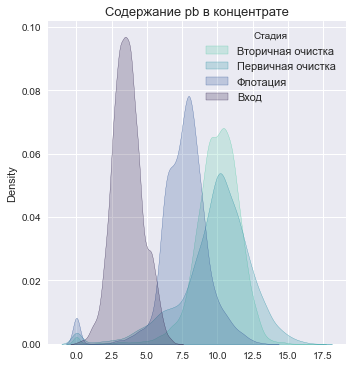

In [20]:
for metal in [au, ag, pb]:
    g = sns.displot(gold_recovery.loc[:, metal[1]], kind="kde", fill=True, palette="mako", legend=False)
    plt.title(f'Содержание {metal[0]} в концентрате', fontsize=13)
    plt.legend(['Вторичная очистка', 'Первичная очистка', 'Флотация', 'Вход'], title='Стадия', fontsize=11)

Содержание золота по мере очистки ожидаемо растет. Металлы-примеси в тоже время ведут себя по разному: содержание серебра снижается, а свинца увеличивается. Также обращает на себя внимание большое количество нулевых значений.

### Размер рудной фракции

Посмотрим как отличается размер гранул руды в тренировочной и тестовой выборке. Данный показатель отслеживается на входе в процессы флотации и первичной очистки.

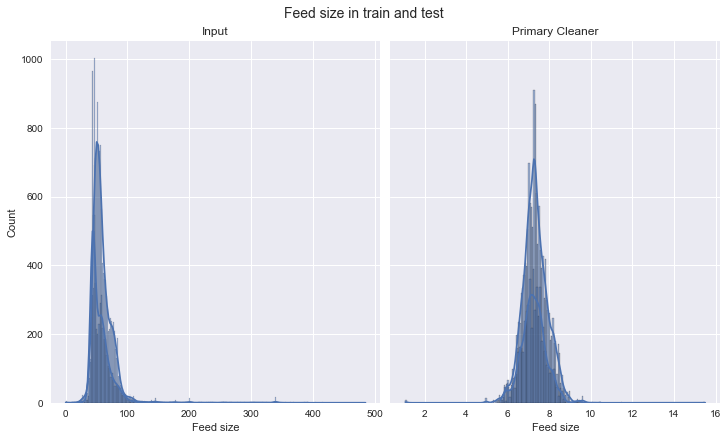

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharey=True, constrained_layout=True)
fig.suptitle('Feed size in train and test', fontsize=14)
cols = ['rougher.input.feed_size', 'primary_cleaner.input.feed_size']

for col, ax, stage in zip(cols, axes, ['Input', 'Primary Cleaner']):
    ax.set_title(stage)
    ax.set_xlabel('Feed size')
    for df in [gold_train, gold_test]:
        sns.histplot(df.loc[:, col], kde=True, palette="rocket", ax=ax)
    

В целом размер рудной фракции имеет схожее распределение в тренировочной и тестовой выборках. Обращает внимание наличие длинного правого хвоста на входе и более однородное распределение фракции после флотации.  

### Суммарная концентрация веществ

Посмотрим как складывается общая концентрация веществ по этапам.

In [22]:
# задаем столбцы, содержащие концентрацию элементов
input_con_cols = list(gold_recovery.columns[gold_recovery.columns.str.contains('rougher.input.feed')])
del input_con_cols[2:4]
rougher_con_cols = list(gold_recovery.columns[gold_recovery.columns.str.contains('rougher.output.concentrate')])
p_cleaner_con_cols = list(gold_recovery.columns[gold_recovery.columns.str.contains('primary_cleaner.output.concentrate')])
output_con_col = list(gold_recovery.columns[gold_recovery.columns.str.contains('final.output.concentrate')])

# создаем столбцы с суммой веществ в концентрате в базовом сете
gold_recovery = (gold_recovery
                .assign(
                    input_con = lambda x: x[input_con_cols].sum(1),
                    rougher_con = lambda x: x[rougher_con_cols].sum(1),
                    p_cleaner_con = lambda x: x[p_cleaner_con_cols].sum(1),
                    output_con = lambda x: x[output_con_col].sum(1)
                    )
                )
# количество нулей в столбцах
zero_con = [len(gold_recovery[gold_recovery[x] == 0])
            for x in ['input_con', 'rougher_con', 'p_cleaner_con', 'output_con']]
con_describe = gold_recovery[['input_con', 'rougher_con', 'p_cleaner_con', 'output_con']].describe()
# добавляем подсчитанные нули в таблицу описания
con_describe.loc['zeros'] = zero_con
con_describe


,input_con,rougher_con,p_cleaner_con,output_con
count,"19,439.000","19,439.000","19,439.000","19,439.000"
mean,57.149,68.145,60.623,68.621
std,7.713,12.540,10.203,7.462
min,0.040,0.000,0.000,0.000
25%,53.508,66.004,58.884,67.928
50%,57.577,70.177,62.491,69.598
75%,61.951,74.357,65.665,71.368
max,76.979,88.140,80.749,80.211
zeros,0.000,394.000,108.000,98.000


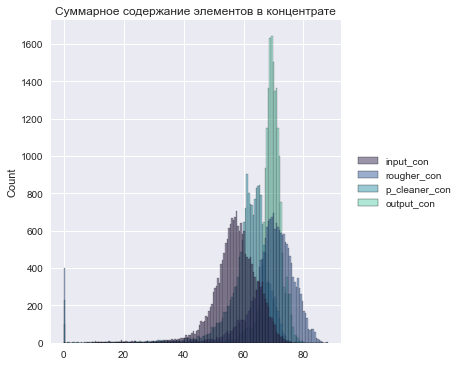

In [23]:
g = sns.displot(gold_recovery[['input_con', 'rougher_con', 'p_cleaner_con', 'output_con']], 
                palette="mako", legend=True)
plt.title(f'Суммарное содержание элементов в концентрате', fontsize=12)
plt.show()

В агрегированных колонках концентрата есть много нулевых значений, что связано скорее всего с ошибками заполнения базы. Эти объекты будут искажать данные в моделировании, поэтому имеет смысл их удалить. Также удалим эти объекты из тренировочной и тестовой выборок, т.к. мы точно будем на них получать нулевую метрику recovery.

In [24]:
# создаем столбцы с суммой веществ в концентрате в train
gold_train = (gold_train
                .assign(
                    input_con = lambda x: x[input_con_cols].sum(1),
                    rougher_con = lambda x: x[rougher_con_cols].sum(1),
                    p_cleaner_con = lambda x: x[p_cleaner_con_cols].sum(1),
                    output_con = lambda x: x[output_con_col].sum(1)
                    )
                )
# количество нулей в столбцах
zero_con = [len(gold_train[gold_train[x] == 0])
            for x in ['input_con', 'rougher_con', 'p_cleaner_con', 'output_con']]
con_describe = gold_train[['input_con', 'rougher_con', 'p_cleaner_con', 'output_con']].describe()
# добавляем подсчитанные нули в таблицу описания
con_describe.loc['zeros'] = zero_con
con_describe

,input_con,rougher_con,p_cleaner_con,output_con
count,"14,149.000","14,149.000","14,149.000","14,149.000"
mean,56.056,67.139,60.029,68.343
std,7.561,12.774,10.617,7.072
min,0.040,0.000,0.000,0.000
25%,52.538,64.902,57.979,67.558
50%,56.604,69.174,61.752,69.141
75%,60.762,73.429,65.352,70.975
max,74.458,88.140,76.918,80.211
zeros,0.000,297.000,74.000,58.000


In [25]:
gold_recovery_test = gold_recovery.loc[gold_test.index].copy()

print(gold_recovery_test.shape, gold_train.shape)
# удаляем нулевые значения в концентрациях в полном сете
for col in ['input_con', 'rougher_con', 'p_cleaner_con', 'output_con']:
    gold_recovery_test = gold_recovery_test[gold_recovery_test[col] > 0]
    
# то же самое в трейне
for col in ['input_con', 'rougher_con', 'p_cleaner_con', 'output_con']:
    gold_train = gold_train[gold_train[col] > 0]
    
# приводим в соответствие тестовую выборку
gold_test = gold_test.loc[gold_recovery_test.index]
    
(gold_recovery_test.shape, gold_train.shape)

(5290, 90) (14149, 90)


((5123, 90), (13725, 90))

На стадии первичной очистки все равно осталось какое-то количество аномально малых значений (<1), но скорее всего это не будет мешать построению моделей.

## Модель

### Подготовка выборок

Нам необходимо спрогнозировать эффективность обогащения (recovery) в процессе флотации и в целом по всем процессам. Соответственно, **целевыми переменными** выступают rougher.output.recovery и final.output.recovery.

Для подготовки данных к использованию в моделях машинного обучения
1. Удалим из тренировочной выборки все признаки, которых нет в тестовой
2. Разделим данные на целевой признак и все остальные
3. Избавимся от пропусков


In [26]:
# целевые признаки 
target = ['rougher.output.recovery', 'final.output.recovery']

Y_train = gold_train[target]
X_train = gold_train[gold_test.columns]

Y_test = gold_recovery[target].loc[gold_test.index]
X_test = gold_test

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((13725, 52), (13725, 2), (5123, 52), (5123, 2))

In [27]:
# проверим наличие пропусков в выборках
X_train.isnull().sum().sort_values(ascending=False).head(10)

rougher.input.feed_size                       138
rougher.input.feed_pb                         100
primary_cleaner.input.xanthate                 86
rougher.input.feed_sol                         62
primary_cleaner.input.depressant               17
rougher.input.feed_rate                         8
primary_cleaner.input.sulfate                   6
secondary_cleaner.state.floatbank5_a_air        0
secondary_cleaner.state.floatbank4_b_level      0
rougher.state.floatbank10_e_level               0
dtype: int64

Количество пропусков незначительно - почти все ушли с удаленными признаками, поэтому просто удалим их.

In [28]:
X_train = X_train.dropna()
Y_train = Y_train.loc[X_train.index]

X_test = X_test.dropna()
Y_test = Y_test.loc[X_test.index]

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((13331, 52), (13331, 2), (5074, 52), (5074, 2))

In [29]:
# разделим целевые признаки
Y_train_rougher = Y_train['rougher.output.recovery']
Y_train_final = Y_train['final.output.recovery']

Y_test_rougher = Y_test['rougher.output.recovery']
Y_test_final = Y_test['final.output.recovery']

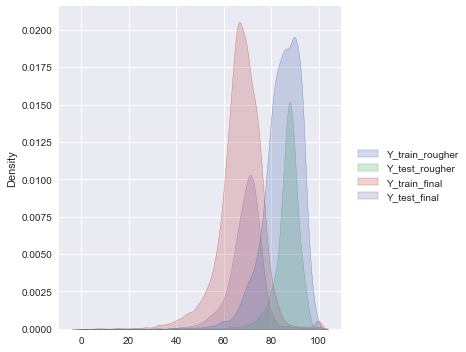

In [30]:
sns.displot({'Y_train_rougher':Y_train_rougher, 'Y_test_rougher': Y_test_rougher,
             'Y_train_final': Y_train_final, 'Y_test_final': Y_test_final}, kind='kde', fill=True)

### Метрика модели 

Для оценки моделей будем использовать метрику качества — sMAPE (Symmetric Mean Absolute Percentage Error) - «симметричное среднее абсолютное процентное отклонение»:

\begin{align}
{sMAPE} = \frac{1}{N} \sum_{i=1}^{N}\frac{|y_i-\hat{y_i}|}{(|y_i|+|\hat{y_i}|)/2}\times100\%
\end{align}

Нужно спрогнозировать сразу две величины:
* эффективность обогащения чернового концентрата rougher.output.recovery;
* эффективность обогащения финального концентрата final.output.recovery.

Итоговая метрика складывается из двух величин:

\begin{align}
{Итоговое\ sMAPE} = 25\% \times sMAPE(rougher) + 75\% \times sMAPE(final)
\end{align}

In [31]:
# sMAPE
def smape (target, predictions):
    return 100/len(target) * np.sum(2 * np.abs(predictions - target) / (np.abs(target) + np.abs(predictions)))

# итоговый sMAPE
def final_smape (rougher, final):
    return 0.25 * rougher + 0.75 * final

smape_scorer = make_scorer(smape, greater_is_better=False)

### Моделирование

Осуществим масштабирование признаков.

In [32]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [33]:
# lr = LinearRegression().fit(X_train, Y_train_rougher)
# cross_val_score(lr, X_train, Y_train_rougher, cv=3, scoring=smape_scorer)

In [34]:
cv = KFold()

pipe = Pipeline([('model', RandomForestRegressor(random_state=SEED))])

grid_par = [
    {
        'model': [RandomForestRegressor(random_state=SEED)],
        'model__max_depth': [3, 6, 9],
        'model__n_estimators': [20, 50, 100],
    }, 
    {
        'model': [DecisionTreeRegressor(random_state=SEED)],
        'model__max_depth': [3, 6, 9],
    }, 
    {
        'model': [LinearRegression()],
    }
]

In [35]:
%%time
grid_rougher = GridSearchCV(estimator=pipe, param_grid=grid_par, cv=cv, scoring=smape_scorer, n_jobs=-1)
grid_rougher.fit(X_train, Y_train_rougher)

CPU times: total: 16 s
Wall time: 2min 58s


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('model',
                                        RandomForestRegressor(random_state=666))]),
             n_jobs=-1,
             param_grid=[{'model': [RandomForestRegressor(max_depth=6,
                                                          n_estimators=50,
                                                          random_state=666)],
                          'model__max_depth': [3, 6, 9],
                          'model__n_estimators': [20, 50, 100]},
                         {'model': [DecisionTreeRegressor(random_state=666)],
                          'model__max_depth': [3, 6, 9]},
                         {'model': [LinearRegression()]}],
             scoring=make_scorer(smape, greater_is_better=False))

In [36]:
print('Rougher stage results:')
grid_rougher.best_estimator_, grid_rougher.best_params_, grid_rougher.best_score_

Rougher stage results:


(Pipeline(steps=[('model',
                  RandomForestRegressor(max_depth=6, n_estimators=50,
                                        random_state=666))]),
 {'model': RandomForestRegressor(max_depth=6, n_estimators=50, random_state=666),
  'model__max_depth': 6,
  'model__n_estimators': 50},
 -6.173733537288055)

In [37]:
%%time
grid_final = GridSearchCV(estimator=pipe, param_grid=grid_par, cv=cv, scoring=smape_scorer, n_jobs=-1)
grid_final.fit(X_train, Y_train_final)

CPU times: total: 6.41 s
Wall time: 2min 58s


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('model',
                                        RandomForestRegressor(random_state=666))]),
             n_jobs=-1,
             param_grid=[{'model': [RandomForestRegressor(max_depth=3,
                                                          n_estimators=50,
                                                          random_state=666)],
                          'model__max_depth': [3, 6, 9],
                          'model__n_estimators': [20, 50, 100]},
                         {'model': [DecisionTreeRegressor(random_state=666)],
                          'model__max_depth': [3, 6, 9]},
                         {'model': [LinearRegression()]}],
             scoring=make_scorer(smape, greater_is_better=False))

In [38]:
print('Final stage results:')
grid_final.best_estimator_, grid_final.best_params_, grid_final.best_score_

Final stage results:


(Pipeline(steps=[('model',
                  RandomForestRegressor(max_depth=3, n_estimators=50,
                                        random_state=666))]),
 {'model': RandomForestRegressor(max_depth=3, n_estimators=50, random_state=666),
  'model__max_depth': 3,
  'model__n_estimators': 50},
 -8.663433850755071)

RandomForestRegressor - модель, показавшая лучший результат на тренировочной выборке. Проведем обучение и проверку модели с лучшими параметрами на тестовой выборке.

### Проверка на тестовой выборке

In [39]:
%%time

model = RandomForestRegressor(max_depth=6, n_estimators=50, random_state=SEED)

# rougher
model.fit(X_train, Y_train_rougher)
rougher_pred = model.predict(X_test)
rougher_smape = smape(Y_test_rougher, rougher_pred)
print('Rougher stage sMAPE:', rougher_smape)

# final
model = RandomForestRegressor(max_depth=3, n_estimators=50, random_state=SEED)
model.fit(X_train, Y_train_final)
fin_pred = model.predict(X_test)
fin_smape = smape(Y_test_final, fin_pred)
print('Final stage sMAPE:', fin_smape)

# итог
total_smape = final_smape(rougher_smape, fin_smape)
print('Агрегированный показатель эффективности:', total_smape)

Rougher stage sMAPE: 4.198168964414623
Final stage sMAPE: 7.853097013567039
Агрегированный показатель эффективности: 6.939365001278936
CPU times: total: 17.3 s
Wall time: 18.6 s


Сравним результаты с константной моделью

In [40]:
dummy_regressor = DummyRegressor(strategy='median')

# rougher
dummy_regressor.fit(X_train, Y_train_rougher)
dummy_predict_rougher = dummy_regressor.predict(X_test)
rougher_dummy_smape = smape(Y_test_rougher, dummy_predict_rougher)
rougher_dummy_smape

4.648373763657533

In [41]:
# final
dummy_regressor.fit(X_train, Y_train_final)
dummy_predict_final = dummy_regressor.predict(X_test)
final_dummy_smape = smape(Y_test_final, dummy_predict_final)
final_dummy_smape

8.08547954513876

In [ ]:
dummy_smape = final_smape(rougher_dummy_smape, final_dummy_smape)
print('Агрегированный показатель эффективности константной модели:', dummy_smape)